# Human Image Segmentation using U-Net (PyTorch)

## Overview
This project focuses on **human image segmentation** using a deep learning model based on **U-Net architecture** implemented in **PyTorch**.

The goal is to accurately segment human silhouettes from input images using a supervised learning approach.

## Key Features
- U-Net based segmentation model
- PyTorch implementation
- Albumentations for image-mask augmentation
- Binary segmentation with Dice Loss
- GPU training support

## Dataset
Human Segmentation Dataset  
Original dataset author: https://github.com/ali-mohamadpour/human-segmentation-unet/data

## Output
The model predicts a binary mask highlighting the human region in the image.



# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pu8qy0db
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pu8qy0db
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/ali-mohamadpour/human-segmentation-unet/data


In [ ]:
!git clone https://github.com/ali-mohamadpour/human-segmentation-unet.git


fatal: destination path 'human-segmentation-unet' already exists and is not an empty directory.


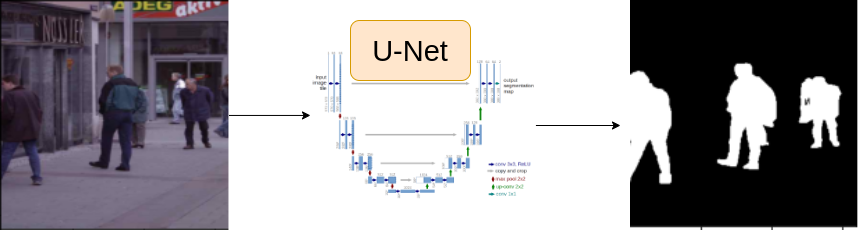

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/human-segmentation-unet')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
CONFIG = {
    "IMAGE_SIZE": 256,
    "BATCH_SIZE": 8,
    "EPOCHS": 25,
    "LR": 1e-4
}


In [ ]:
torch.manual_seed(42)
np.random.seed(42)

image = cv2.cvtColor(
    cv2.imread('/content/human-segmentation-unet/data/Training_Images/100.jpg'),
    cv2.COLOR_BGR2RGB
)

mask = cv2.imread(
    '/content/human-segmentation-unet/data/Ground_Truth/100.png',
    0
)



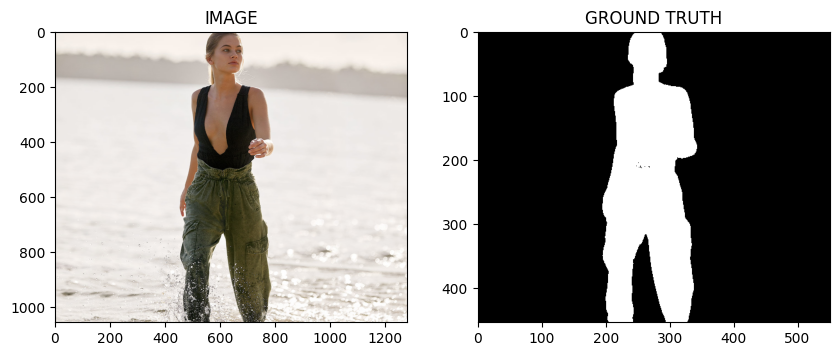

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(height=CONFIG["IMAGE_SIZE"], width=CONFIG["IMAGE_SIZE"]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
val_transform = A.Compose([
    A.Resize(height=CONFIG["IMAGE_SIZE"], width=CONFIG["IMAGE_SIZE"]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class HumanSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask



In [ ]:
image_dir = '/content/human-segmentation-unet/data/Training_Images'
mask_dir = '/content/human-segmentation-unet/data/Ground_Truth'

all_images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
all_masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

train_imgs, val_imgs, train_masks, val_masks = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)


In [ ]:
trainset = HumanSegDataset(train_imgs, train_masks, transform=train_transform)
validset = HumanSegDataset(val_imgs, val_masks, transform=val_transform)

train_loader = DataLoader(trainset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
valid_loader = DataLoader(validset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)


In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [ ]:
sample_img, sample_mask = next(iter(train_loader))
print(f"Sample image shape: {sample_img.shape}")
print(f"Sample mask shape: {sample_mask.shape}")


Sample image shape: torch.Size([8, 3, 256, 256])
Sample mask shape: torch.Size([8, 256, 256])


# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
train_loader = DataLoader(
    trainset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    num_workers=2
)


In [ ]:
valid_loader = DataLoader(
    validset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    num_workers=2
)


In [ ]:
sample_imgs, sample_masks = next(iter(train_loader))
print(f"Train batch images shape: {sample_imgs.shape}")
print(f"Train batch masks shape: {sample_masks.shape}")


Train batch images shape: torch.Size([8, 3, 256, 256])
Train batch masks shape: torch.Size([8, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp


In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["LR"])


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(loader, model, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


In [ ]:
def valid_fn(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss





# Task 8 : Train Model



In [ ]:
num_epochs = CONFIG["EPOCHS"]

for epoch in range(num_epochs):
    train_loss = train_fn(train_loader, model, optimizer, criterion, DEVICE)
    valid_loss = valid_fn(valid_loader, model, criterion, DEVICE)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")


Epoch [1/25] | Train Loss: -17085.4786 | Valid Loss: -15004.9081
Epoch [2/25] | Train Loss: -17144.2121 | Valid Loss: -15309.8965
Epoch [3/25] | Train Loss: -17345.1420 | Valid Loss: -15577.4634
Epoch [4/25] | Train Loss: -17444.7923 | Valid Loss: -15497.5589
Epoch [5/25] | Train Loss: -17592.3748 | Valid Loss: -15797.1756
Epoch [6/25] | Train Loss: -17721.2367 | Valid Loss: -15582.2751
Epoch [7/25] | Train Loss: -17825.8726 | Valid Loss: -16286.8664
Epoch [8/25] | Train Loss: -17955.3745 | Valid Loss: -15851.0892
Epoch [9/25] | Train Loss: -18117.8726 | Valid Loss: -16715.1526
Epoch [10/25] | Train Loss: -18220.3759 | Valid Loss: -16244.6525
Epoch [11/25] | Train Loss: -18412.8439 | Valid Loss: -16406.8368
Epoch [12/25] | Train Loss: -18573.3126 | Valid Loss: -16195.8101
Epoch [13/25] | Train Loss: -18742.2468 | Valid Loss: -16475.8305
Epoch [14/25] | Train Loss: -18840.7999 | Valid Loss: -16771.7109
Epoch [15/25] | Train Loss: -18927.3451 | Valid Loss: -17220.2923
Epoch [16/25] | Tra

#TASK 8: Train model ### Saving the Best Model (Optional but Recommended)



In [ ]:
  num_epochs = CONFIG["EPOCHS"]
best_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_fn(train_loader, model, optimizer, criterion, DEVICE)
    valid_loss = valid_fn(valid_loader, model, criterion, DEVICE)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")


    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved Best Model")



Epoch [1/25] | Train Loss: -20504.3223 | Valid Loss: -18303.3846
Saved Best Model
Epoch [2/25] | Train Loss: -20562.2847 | Valid Loss: -18398.7901
Saved Best Model
Epoch [3/25] | Train Loss: -20847.7599 | Valid Loss: -18874.6588
Saved Best Model
Epoch [4/25] | Train Loss: -20890.4548 | Valid Loss: -18624.5001
Epoch [5/25] | Train Loss: -21094.6472 | Valid Loss: -18234.2258
Epoch [6/25] | Train Loss: -21221.4758 | Valid Loss: -17978.2854
Epoch [7/25] | Train Loss: -21408.9215 | Valid Loss: -18929.1086
Saved Best Model
Epoch [8/25] | Train Loss: -21546.7265 | Valid Loss: -19379.1137
Saved Best Model
Epoch [9/25] | Train Loss: -21656.6585 | Valid Loss: -19378.0875
Epoch [10/25] | Train Loss: -21808.8955 | Valid Loss: -19137.2684
Epoch [11/25] | Train Loss: -21939.8541 | Valid Loss: -19879.9118
Saved Best Model
Epoch [12/25] | Train Loss: -22153.8631 | Valid Loss: -19604.4632
Epoch [13/25] | Train Loss: -22227.9438 | Valid Loss: -19122.2391
Epoch [14/25] | Train Loss: -22359.7874 | Valid L

# Task 9 : Inference

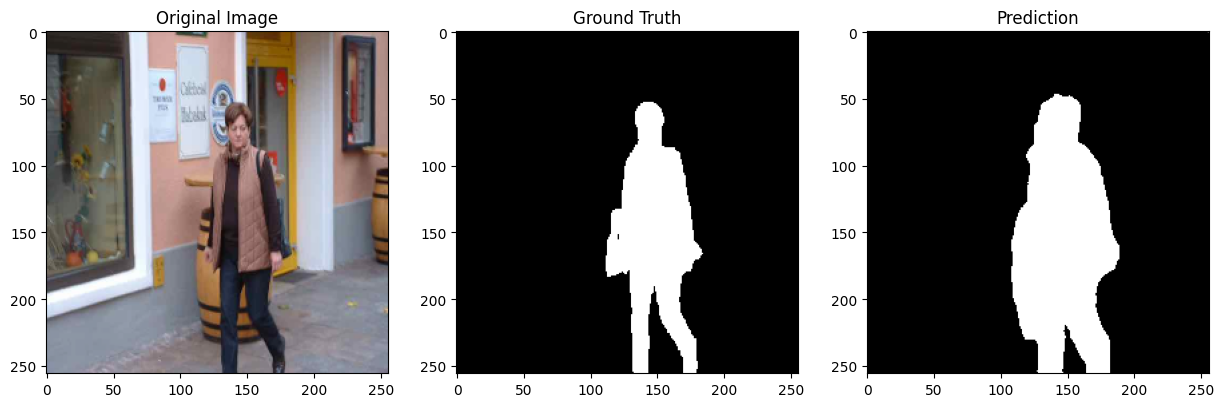

In [ ]:
import torch
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

images, masks = next(iter(valid_loader))
images = images.to(DEVICE)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()


image = images[0].cpu().permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = image * std + mean
image = np.clip(image, 0, 1)

mask = masks[0].cpu().numpy()
pred = preds[0].cpu().squeeze().numpy()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.set_title("Original Image")
ax1.imshow(image)
ax2.set_title("Ground Truth")
ax2.imshow(mask, cmap="gray")
ax3.set_title("Prediction")
ax3.imshow(pred, cmap="gray")
plt.show()



##  Acknowledgements

Thank you for taking the time to explore this project, run the code, and review the implementation.  
Your feedback, suggestions, and contributions are greatly appreciated and can help improve this project.
 follow me on...

Linkedin : www.linkedin.com/in/ali-mohamaadpour